In [ ]:
from IPython.display import clear_output

!pip install pennylane
clear_output()

In [1]:
import dill
dill.load_session('notebook_env.db')

AttributeError: 'bool' object has no attribute '__setstate__'

Coordinate 0 :  0.30923
Total number of excitations = 26
n = 0,  E = -100.83978120 H, Largest Gradient = 0.065

n = 1,  E = -100.84188516 H, Largest Gradient = 0.048

n = 2,  E = -100.84335743 H, Largest Gradient = 0.041

n = 3,  E = -100.84422618 H, Largest Gradient = 0.031

n = 4,  E = -100.84483282 H, Largest Gradient = 0.019

n = 5,  E = -100.84500914 H, Largest Gradient = 0.018

n = 6,  E = -100.84517637 H, Largest Gradient = 0.009

n = 7,  E = -100.84522581 H, Largest Gradient = 0.009

n = 8,  E = -100.84527550 H, Largest Gradient = 0.006

n = 9,  E = -100.84530068 H, Largest Gradient = 0.006

n = 10,  E = -100.84532597 H, Largest Gradient = 0.003

n = 11,  E = -100.84533091 H, Largest Gradient = 0.003

n = 12,  E = -100.84533564 H, Largest Gradient = 0.002

n = 13,  E = -100.84533888 H, Largest Gradient = 0.002

n = 14,  E = -100.84534188 H, Largest Gradient = 0.002

n = 15,  E = -100.84534363 H, Largest Gradient = 0.002

n = 16,  E = -100.84534574 H, Largest Gradient = 0.002

n

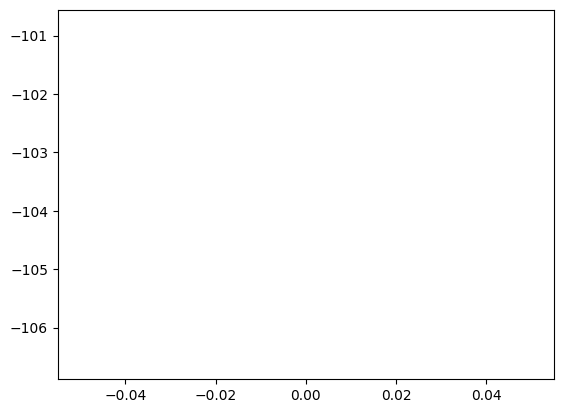

In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import copy

from pennylane import qchem
from pennylane import numpy as pnp
from pennylane.optimize.adaptive import AdaptiveOptimizer
from pennylane.optimize.adaptive import append_gate

A_to_au_conversion = 1.8897259885789

class CustomOptimizer(AdaptiveOptimizer):
    def custom_step(self, circuit, operator_pool, drain_pool=False, params_zero=True):
        cost = circuit()
        qnode = copy.copy(circuit)
        if drain_pool:
            operator_pool = [
                gate
                for gate in operator_pool
                if all(
                    gate.name != operation.name or gate.wires != operation.wires
                    for operation in circuit.tape.operations
                )
            ]

        params = pnp.array([gate.parameters[0] for gate in operator_pool], requires_grad=True)
        qnode.func = self._circuit
        grads = qml.grad(qnode)(params, gates=operator_pool, initial_circuit=circuit.func)
        selected_gates = [operator_pool[pnp.argmax(abs(grads))]]

        ######################################################
        optimizer = qml.GradientDescentOptimizer(stepsize=self.stepsize)
        ######################################################

        # AdagradOptimizer, RMSPropOptimizer
        # GradientDescentOptimizer, AdamOptimizer, MomentumOptimizer, NesterovMomentumOptimizer, QNGOptimizer, ShotAdaptiveOptimizer
        # QNSPSAOptimizer, RiemannianGradientOptimizer, RotoselectOptimizer, RotosolveOptimizer, SPSAOptimizer

        if params_zero:
            params = pnp.zeros(len(selected_gates))
        else:
            params = pnp.array([gate.parameters[0] for gate in selected_gates], requires_grad=True)

        for _ in range(self.param_steps):
            # print('Gates: ', selected_gates)
            # print('initial circuit: ', circuit.func)
            params, _ = optimizer.step_and_cost(
                qnode, params, gates=selected_gates, initial_circuit=circuit.func
            )

        qnode.func = append_gate(circuit.func, params, selected_gates)

        return qnode, cost, max(abs(qml.math.toarray(grads)))


def calc_adapt_vqe_N2H4(d, threshold, active_electrons=4, active_orbitals=4):
    symbols = ["N", "H", "H", "N", "H", "H"]
    # ground state coordinate:
    geometry = pnp.array([-0.70923700, -0.07410500, -0.09808600, -1.05902700, 0.83399100, -0.38582400, -1.14482800, -0.31562300, 0.78209700,  d, -0.07385300, 0.09826900, 1.14485300, -0.31762400, -0.78127500, 1.05905100, 0.83496100, 0.38372100 ])

    H, qubits = qchem.molecular_hamiltonian(
        symbols,
        geometry,
        active_electrons=active_electrons,
        active_orbitals=active_orbitals,
        ######################################################
        basis='sto-3g'
        ######################################################
        # method="pyscf"
    )
    active_electrons = active_electrons
    singles, doubles = qchem.excitations(active_electrons, qubits)
    print(f"Total number of excitations = {len(singles) + len(doubles)}")
    singles_excitations = [qml.SingleExcitation(0.0, x) for x in singles]
    doubles_excitations = [qml.DoubleExcitation(0.0, x) for x in doubles]
    operator_pool = doubles_excitations + singles_excitations
    hf_state = qchem.hf_state(active_electrons, qubits)
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit():
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]
        return qml.expval(H)
    energy_array = []
    circuit_array = []

    opt = CustomOptimizer()
    for i in range(len(operator_pool)):
        circuit, energy, gradient = opt.custom_step(circuit, operator_pool)

        energy_array.append(energy)
        circuit_array.append(circuit)

        if i % 1 == 0:
            print("n = {:},  E = {:.8f} H, Largest Gradient = {:.3f}".format(i, energy, gradient))
            # print(qml.draw(circuit, decimals=None)())
            print()
        if gradient < threshold*10^(-threshold):
            break
    return energy_array, circuit_array


######################################################
config = [[2,2]]
threshold = 3
setting='basis-sto-3g'
######################################################


ref = 0.70923000
n = 10

d = np.arange(ref-0.1*4, ref+0.1*(n+1), 0.1)

# print(d)

energies_pes = []
circuit_array_pes = []
energies_pes_full = []

for i in range(len(d)):
    print(f'Coordinate {i} : ', d[i])
    energy, circuit_array = calc_adapt_vqe_N2H4(d[i], 3)
    energies_pes.append(energy[-1])
    energies_pes_full.append(energy)
    circuit_array_pes.append(circuit_array)
    plt.plot(energies_pes[-1])

In [3]:
energies_pes

[tensor(-100.84535169, requires_grad=True),
 tensor(-102.29557499, requires_grad=True),
 tensor(-103.31509883, requires_grad=True),
 tensor(-104.01374761, requires_grad=True),
 tensor(-104.47952777, requires_grad=True),
 tensor(-104.78537274, requires_grad=True),
 tensor(-104.99267819, requires_grad=True),
 tensor(-105.15256082, requires_grad=True),
 tensor(-105.30416381, requires_grad=True),
 tensor(-105.47263564, requires_grad=True),
 tensor(-105.66872724, requires_grad=True),
 tensor(-105.89058021, requires_grad=True),
 tensor(-106.12805835, requires_grad=True),
 tensor(-106.36789752, requires_grad=True),
 tensor(-106.59784258, requires_grad=True)]

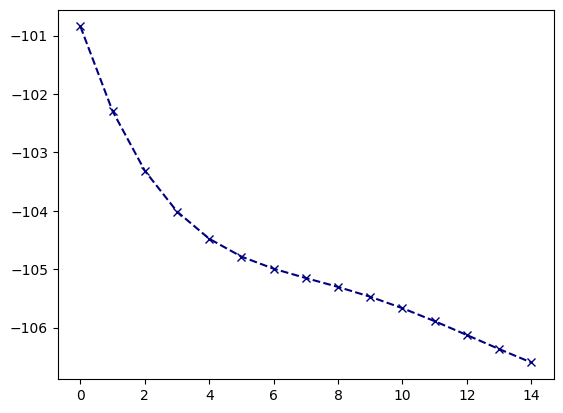

In [9]:
plt.plot(energies_pes, marker='x', linestyle='--', color='navy')

In [10]:
energies_pes_full

[[tensor(-100.8397812, requires_grad=True),
  tensor(-100.84188516, requires_grad=True),
  tensor(-100.84335743, requires_grad=True),
  tensor(-100.84422618, requires_grad=True),
  tensor(-100.84483282, requires_grad=True),
  tensor(-100.84500914, requires_grad=True),
  tensor(-100.84517637, requires_grad=True),
  tensor(-100.84522581, requires_grad=True),
  tensor(-100.8452755, requires_grad=True),
  tensor(-100.84530068, requires_grad=True),
  tensor(-100.84532597, requires_grad=True),
  tensor(-100.84533091, requires_grad=True),
  tensor(-100.84533564, requires_grad=True),
  tensor(-100.84533888, requires_grad=True),
  tensor(-100.84534188, requires_grad=True),
  tensor(-100.84534363, requires_grad=True),
  tensor(-100.84534574, requires_grad=True),
  tensor(-100.84534787, requires_grad=True),
  tensor(-100.84534959, requires_grad=True),
  tensor(-100.84535019, requires_grad=True),
  tensor(-100.84535074, requires_grad=True),
  tensor(-100.84535099, requires_grad=True),
  tensor(-10

In [11]:
len(circuit_array_pes)

15

In [12]:
circuit_array_pes[0]

[<QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>,
 <QNode: device='<d

In [13]:

for j in range(len(circuit_array_pes)):
    print('\n=== Circuit Array Iteration ', j+1, '===')
    gates = []
    depths = []
    for i in range(len(circuit_array_pes[j])):
        spec = qml.specs(circuit_array_pes[j][i], expansion_strategy="device")
        gate = spec()['resources'].num_gates
        depth = spec()['resources'].depth
        gates.append(gate)
        depths.append(depth)

        print('\n=== ADAPT Iteration ', i+1, '===')
        print(spec()['resources'], '')

        print(qml.draw(circuit_array_pes[0][i], decimals=None)())

        print(circuit_array_pes[0][i])

    # Open file for writing
    with open(f'circuit_array_{j}.txt', 'w') as file:
        # Write header
        file.write("gates,depth,E\n")
        # Write data
        for i in range(len(depths)):
            file.write(f"{depths[i]},{gates[i]}\n")

print("Data saved")

Streaming output truncated to the last 5000 lines.
=== ADAPT Iteration  13 ===
wires: 8
gates: 17
depth: 10
shots: Shots(total=None)
gate_types:
{'PauliX': 4, 'DoubleExcitation': 13}
gate_sizes:
{1: 4, 4: 13} 
0: ──X─╭G²─────────╭G²─────╭G²─────╭G²─────╭G²─────────────┤ ╭<𝓗>
1: ──X─├G²─────────├G²─╭G²─│───╭G²─│───╭G²─│───────────╭G²─┤ ├<𝓗>
2: ──X─│───╭G²─╭G²─│───├G²─│───├G²─│───├G²─│───╭G²─╭G²─├G²─┤ ├<𝓗>
3: ──X─│───├G²─├G²─│───│───├G²─│───├G²─│───├G²─├G²─├G²─│───┤ ├<𝓗>
4: ────│───├G²─│───├G²─│───│───├G²─│───│───├G²─├G²─│───├G²─┤ ├<𝓗>
5: ────│───╰G²─│───╰G²─│───│───│───├G²─├G²─│───│───├G²─╰G²─┤ ├<𝓗>
6: ────├G²─────├G²─────├G²─├G²─│───╰G²─╰G²─│───│───╰G²─────┤ ├<𝓗>
7: ────╰G²─────╰G²─────╰G²─╰G²─╰G²─────────╰G²─╰G²─────────┤ ╰<𝓗>
<QNode: device='<default.qubit device (wires=8) at 0x799a0e6daa10>', interface='auto', diff_method='best'>

=== ADAPT Iteration  14 ===
wires: 8
gates: 18
depth: 10
shots: Shots(total=None)
gate_types:
{'PauliX': 4, 'DoubleExcitation': 14}
gate_sizes:
{1: 4, 4: 

In [15]:
depths

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 10,
 11,
 12,
 13,
 13,
 14,
 15,
 15,
 16,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]